In [1]:
!pip install tensorflow seaborn scikit-learn opencv-python-headless
import os, cv2, random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight


In [2]:
from google.colab import files
import zipfile, os

# 🔹 Subir tu archivo ZIP (por ejemplo fer2013.zip o archive.zip)
uploaded = files.upload()

# 🔹 Cambia este nombre si tu archivo tiene otro nombre distinto
zip_path = "/content/archive.zip"  # escribe aquí el nombre que aparece tras subirlo
extract_path = "/content/dataset"

# 🔹 Extraer el ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Carpetas extraídas:", os.listdir(extract_path))

# 🔹 Define las rutas para train y test
train_path = os.path.join(extract_path, "train")
test_path = os.path.join(extract_path, "test")

print("Train path:", train_path)
print("Test path:", test_path)


Saving archive.zip to archive.zip
✅ Carpetas extraídas: ['train', 'test']
Train path: /content/dataset/train
Test path: /content/dataset/test


Classes found: ['sad', 'surprise', 'angry', 'happy', 'fear', 'neutral']


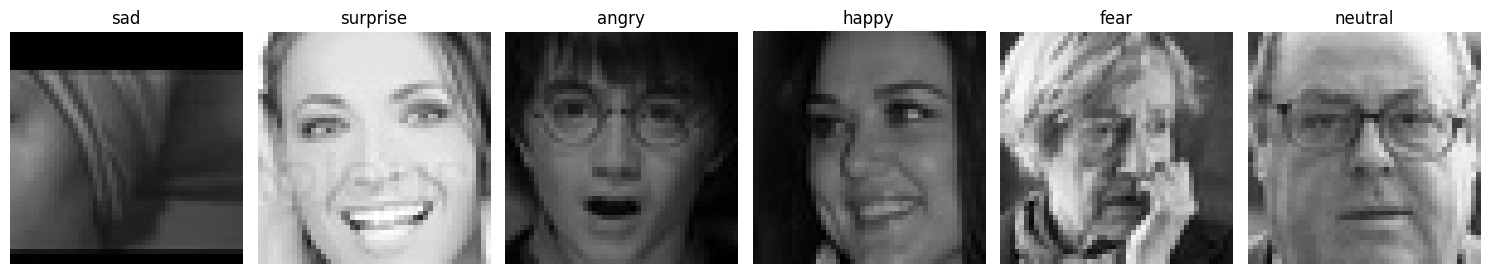

In [3]:
# Listamos las clases dentro de la carpeta train
classes = os.listdir(train_path)
print("Classes found:", classes)

plt.figure(figsize=(15, 5))
 # Obtenemos una imagen aleatoria de cada clase
for i, emotion in enumerate(classes):
    emotion_path = os.path.join(train_path, emotion)
    random_img = random.choice(os.listdir(emotion_path))
    img_path = os.path.join(emotion_path, random_img)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(classes), i+1)
    plt.imshow(img)
    plt.title(emotion)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [4]:
IMG_SIZE = (48, 48)
BATCH_SIZE = 128 # cantidad de imágenes procesadas por lote
EPOCHS = 100 # número de repeticiones del entrenamiento
NUM_CLASSES = 6

In [5]:
# Generador para aumentar los datos de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,        # normaliza valores de 0–255 a 0–1
    rotation_range=20,     # rota imágenes hasta 20 grados
    width_shift_range=0.2, # mueve la imagen horizontalmente
    height_shift_range=0.2,# mueve verticalmente
    shear_range=0.15,      # aplica deformaciones
    zoom_range=0.15,       # hace zoom
    horizontal_flip=True,  # voltea horizontalmente
    validation_split=0.2   # separa 20% de datos para validación
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)
# Generadores para entrenamiento y validación
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


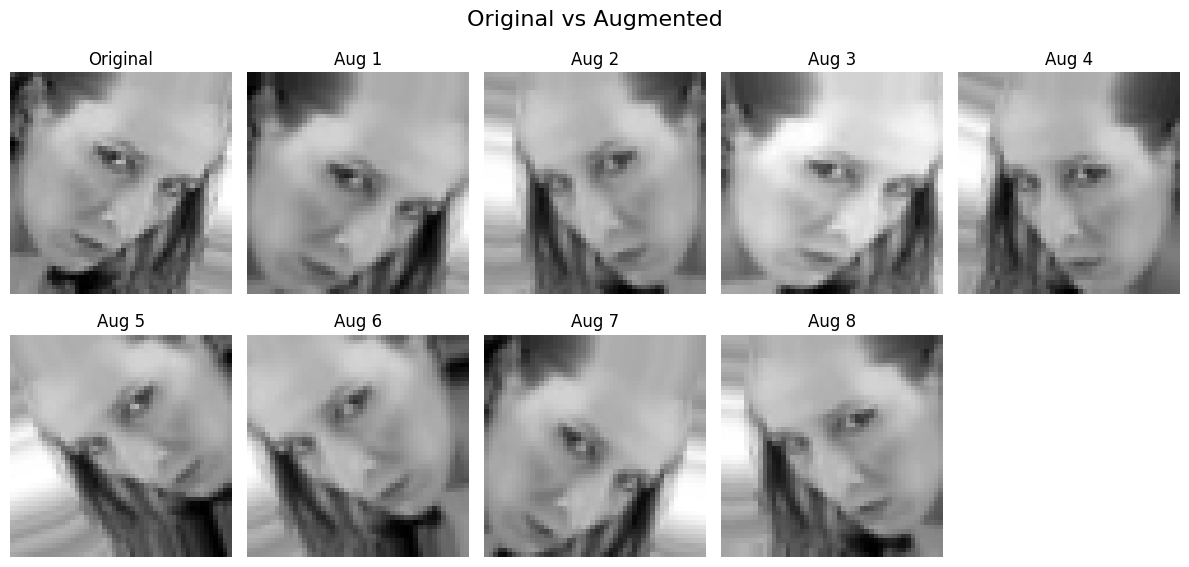

In [6]:
# Visualizamos transformaciones generadas automáticamente
images, labels = next(train_generator)
img = images[0]

plt.figure(figsize=(12, 6))
plt.subplot(2, 5, 1)
plt.imshow(img.reshape(48,48), cmap='gray')
plt.title("Original")
plt.axis('off')

for i in range(8):
    augmented_img = train_datagen.random_transform(img)
    plt.subplot(2, 5, i + 2)
    plt.imshow(augmented_img.reshape(48,48), cmap='gray')
    plt.title(f"Aug {i+1}")
    plt.axis('off')

plt.suptitle("Original vs Augmented", fontsize=16)
plt.tight_layout()
plt.show()


In [6]:
# Construimos una red neuronal convolucional (CNN)
model = Sequential([
    # Block 1
    Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 4
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
# Aplanamos y conectamos a capas densa
    # Dense layers
    Flatten(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
# Compilamos el modelo: definimos cómo aprende
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,945,542 (37.94 MB)

 Trainable params: 9,938,630 (37.91 MB)

 Non-trainable params: 6,912 (27.00 KB)

In [7]:
# Callback para detener el entrenamiento si deja de mejorar
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Callback que reduce la tasa de aprendizaje si no mejora
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

class_labels = train_generator.classes
# Calculamos pesos por clase (si hay clases con menos imágenes)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights_array))
print("Calculated Class Weights:", class_weights)

Calculated Class Weights: {0: np.float64(1.1795473508552357), 1: np.float64(1.1500406752084604), 2: np.float64(0.6531242781242781), 3: np.float64(0.9491020476670023), 4: np.float64(0.9756297446514838), 5: np.float64(1.4859414006043883)}


IMG_SIZE = 48
BATCH_SIZE = 64
EPOCHS = 15

In [8]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 71s 263ms/step - accuracy: 0.1953 - loss: 2.5619 - val_accuracy: 0.1755 - val_loss: 1.8432 - learning_rate: 0.0010
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - accuracy: 0.2383 - loss: 1.9401 - val_accuracy: 0.2048 - val_loss: 1.8771 - learning_rate: 0.0010
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step - accuracy: 0.3012 - loss: 1.7773 - val_accuracy: 0.1767 - val_loss: 2.2173 - learning_rate: 0.0010
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - accuracy: 0.3637 - loss: 1.6224 - val_accuracy: 0.3438 - val_loss: 1.5932 - learning_rate: 0.0010
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - accuracy: 0.4282 - loss: 1.4742 - val_accuracy: 0.3903 - val_loss: 1.5056 - learning_rate: 0.0010
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - accuracy: 0.4724 - loss: 1.3858 - val_accuracy: 0.4197 - val_loss: 1.4741 - learning_rate: 0.0010
Epoch 7/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 25s 140ms/step - accura

56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step
              precision    recall  f1-score   support

       angry       0.59      0.66      0.62       958
        fear       0.56      0.42      0.48      1024
       happy       0.89      0.86      0.87      1774
     neutral       0.56      0.72      0.63      1233
         sad       0.58      0.48      0.52      1247
    surprise       0.74      0.81      0.77       831

    accuracy                           0.67      7067
   macro avg       0.65      0.66      0.65      7067
weighted avg       0.67      0.67      0.67      7067



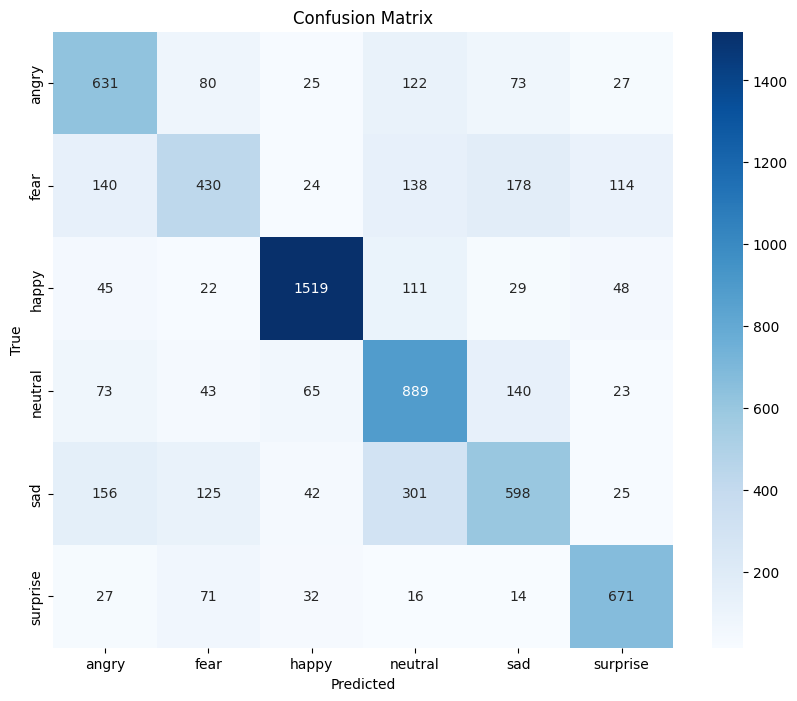

In [9]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred_classes, target_names=list(train_generator.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


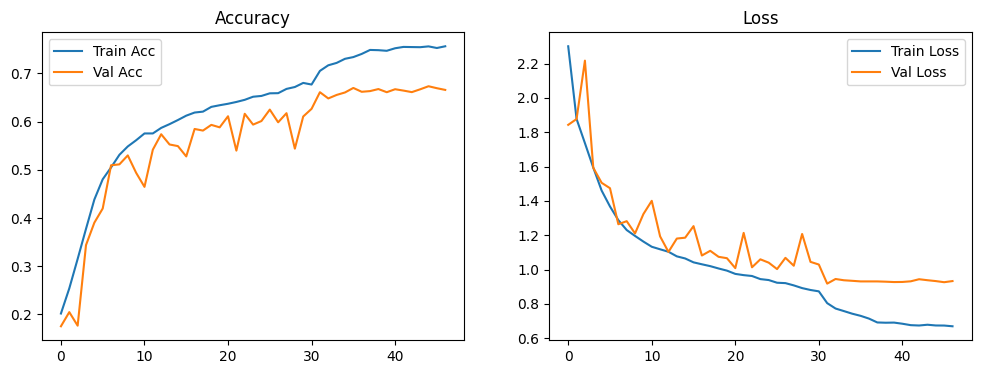

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step


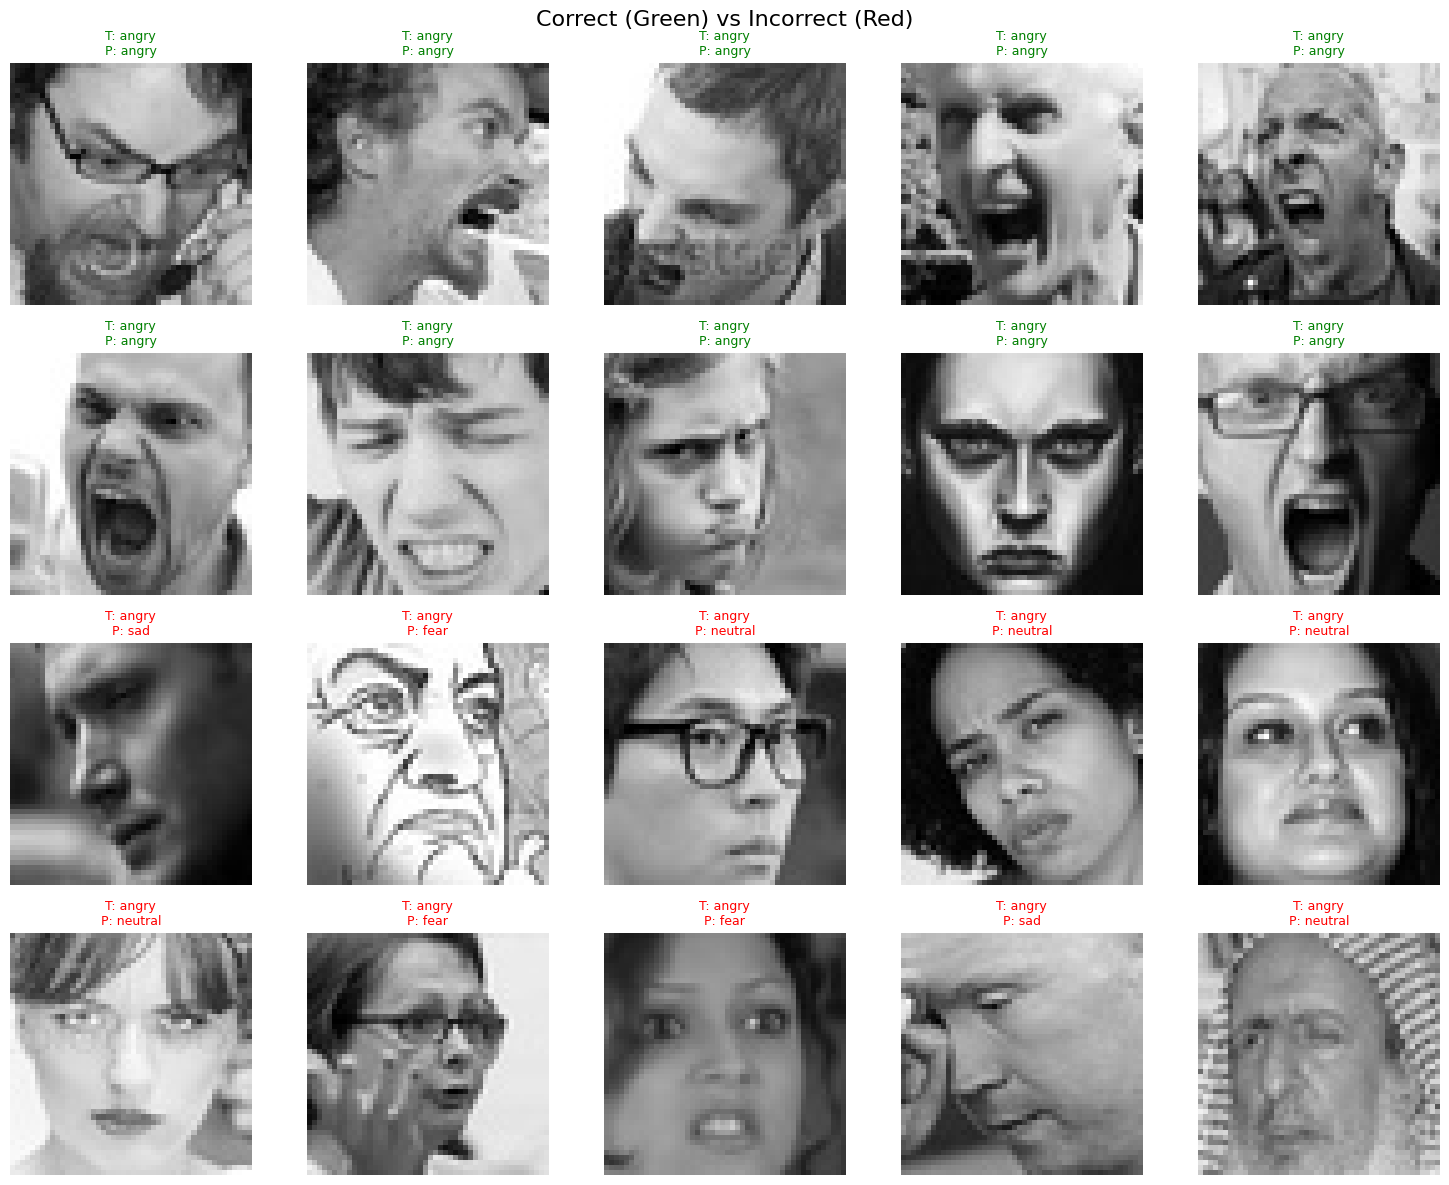

In [11]:
filenames = test_generator.filenames
class_names = list(train_generator.class_indices.keys())
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

correct_idx = np.where(y_true == y_pred)[0]
incorrect_idx = np.where(y_true != y_pred)[0]

n_display = 20
selected_idx = np.concatenate([correct_idx[:n_display//2], incorrect_idx[:n_display//2]])

plt.figure(figsize=(15, 3 * (n_display // 5 + 1)))
for i, idx in enumerate(selected_idx[:n_display]):
    img_path = os.path.join(test_path, filenames[idx])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)

    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    color = 'green' if true_label == pred_label else 'red'

    plt.subplot(n_display // 5 + 1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"T: {true_label}\nP: {pred_label}", color=color, fontsize=9)
    plt.axis('off')

plt.suptitle("Correct (Green) vs Incorrect (Red)", fontsize=16)
plt.tight_layout()
plt.show()
